In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import gamma, gammainc
from scipy.fftpack import fftn, fftshift
from scipy.signal import find_peaks, peak_widths, peak_prominences
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# 1) Input Data

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP")

In [3]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Real Data Sets\First Tel-Aviv data', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
t = f.get('t')
wamos = f.get('wamos')

x = np.array(x)
y = np.array(y)
t = np.array(t)
wamos = np.array(wamos)

dx = x[1] - x[0]
dy = y[1] - y[0]
dt = t[1] - t[0]
dk = 2*np.pi/(dx*min(wamos.shape[0], wamos.shape[1]))

eta = np.transpose(wamos, (1, 2, 0))

Nx, Ny, Nt = eta.shape
    
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) 
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) 
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

Norm = dKx * dKy * dW 

In [5]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

# 2) Getting Triplets

## 2.1) HP Filter

In [6]:
I_0 = power_Spectrum

w_cut = 0.03 * 2*np.pi
w_cut

0.18849555921538758

In [7]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [8]:
I_1 = np.where(mask[ None, None,:], I_0, 0) 

## 2.2) Energy Threshold

In [9]:
P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [10]:
I_2 = np.where(condition[:, :, None], I_1, 0)

## 2.3) Identify Peaks

In [11]:
def identification(kx, ky, ratio, prominence, distance):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)

        if len(peaks) == 1:
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            try_sort = list(set(y[peaks]))
            try_sort.sort()
            ind = np.where(y[peaks]==np.max(y[peaks]))
            thing = []

            for k in range(len(peaks)):
                if np.max(y[peaks]) >= ratio*try_sort[-2]:
                    wj[kx,ky] = w[peaks[ind]]
                    
    return wj 

In [12]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=3, prominence=0.1*np.max(y), distance=10))

In [13]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

w0 = w0_2D[w0_2D != 0]

nonzero_indices = np.nonzero(w0_2D)
nonzero_indices

(array([51, 51, 53, 54, 54, 54, 54, 55, 55, 56, 56, 56, 57, 58, 58, 59, 59,
        59, 60, 60, 60, 61, 61, 61, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63,
        64, 64, 64, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68,
        68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70,
        70, 70, 70, 71, 71, 71, 72, 72, 72, 72, 73, 74, 75, 75, 76, 77, 78],
       dtype=int64),
 array([56, 57, 57, 54, 55, 57, 58, 54, 56, 53, 54, 55, 51, 50, 53, 53, 54,
        78, 49, 51, 53, 50, 52, 53, 46, 73, 80, 47, 49, 53, 69, 73, 74, 76,
        70, 72, 73, 72, 73, 54, 67, 72, 74, 67, 68, 69, 73, 74, 49, 53, 54,
        68, 69, 70, 72, 73, 80, 48, 54, 67, 68, 69, 74, 45, 47, 54, 67, 68,
        73, 75, 76, 49, 67, 74, 50, 65, 67, 73, 49, 48, 50, 80, 76, 75, 52],
       dtype=int64))

In [14]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [15]:
%matplotlib widget

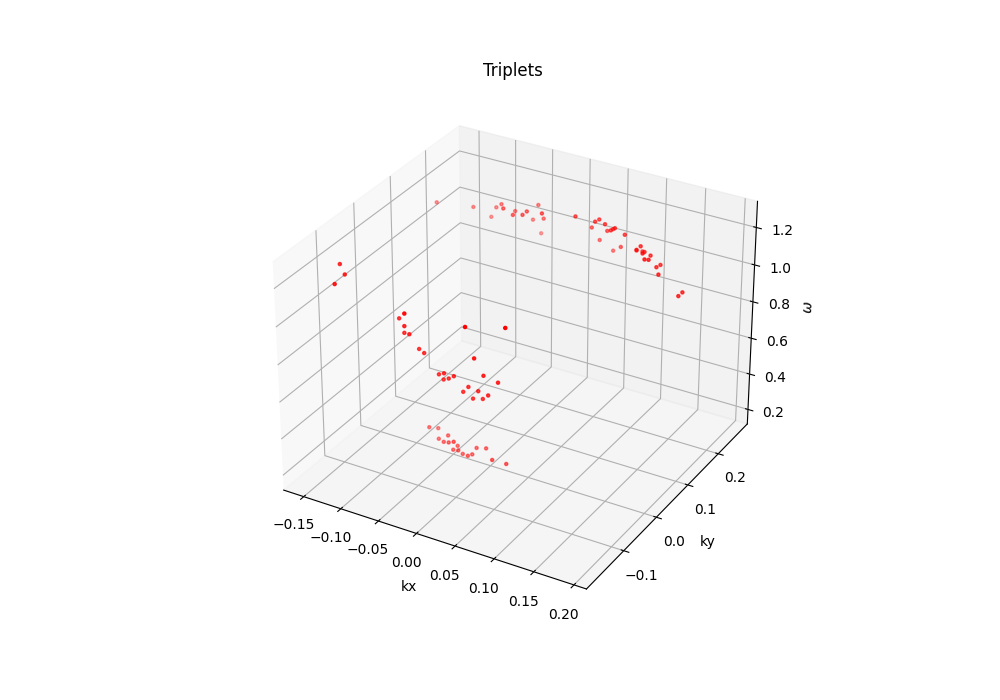

In [16]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip, -ky_trip, w0, color = "red", s = 5)
plt.title("Triplets")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

# show plot
plt.show()

## 2.4) Remove Low Wavenumbers

In [17]:
cond_high_k = (np.abs(-ky_trip) > 0.06)
# removing low wavenumbers

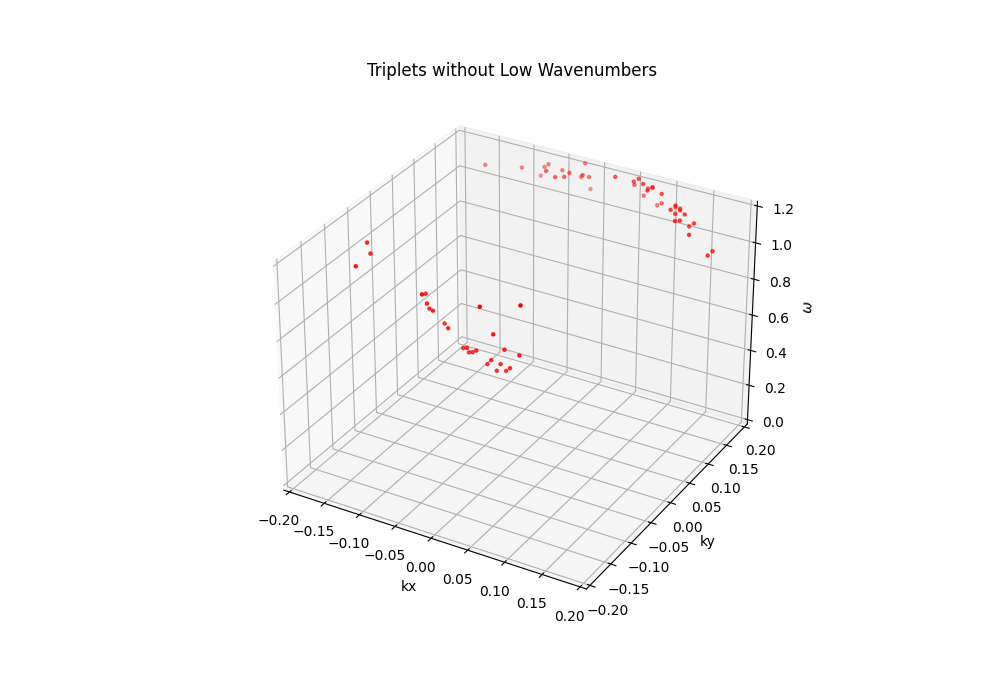

In [19]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k], color = "red", s = 5)
plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.5) Only Consider Aliased Data

In [80]:
all_triplets = (-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k])

In [81]:
cond_alias = (all_triplets[1] > 0)
# Only gives the aliased data

cond_nonalias = (all_triplets[1] < 0)
# Non aliased data

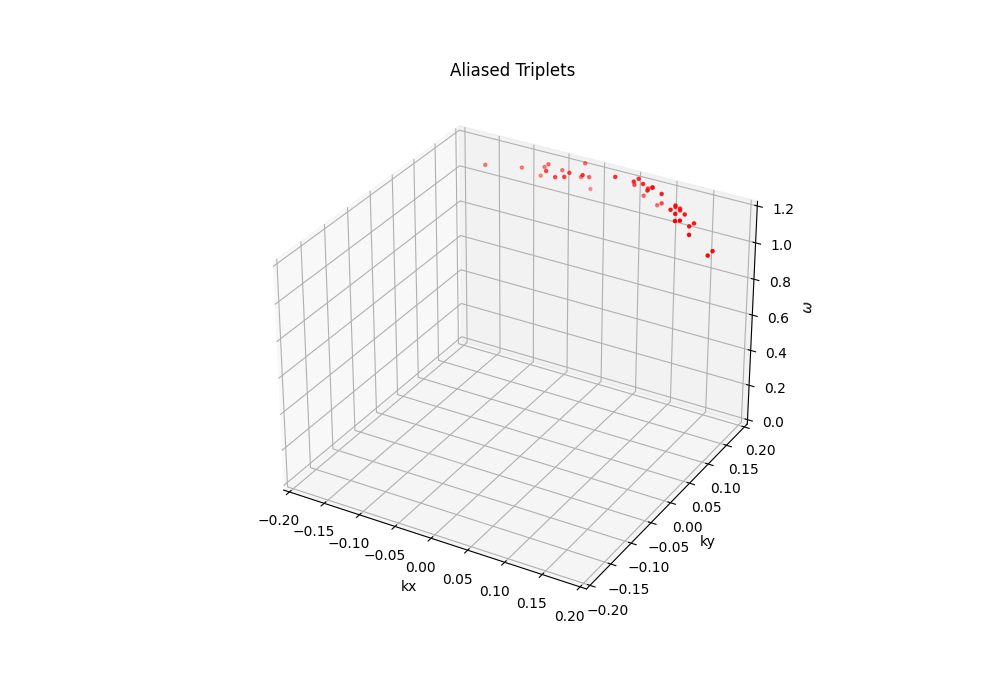

In [82]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D( all_triplets[0][cond_alias],  all_triplets[1][cond_alias],  all_triplets[2][cond_alias], color = "red", s = 5)
plt.title("Aliased Triplets")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.6) Translate Aliased Triplets Across

In [113]:
aliased_triplets = (all_triplets[0][cond_alias],  all_triplets[1][cond_alias],  all_triplets[2][cond_alias])

In [114]:
translated_alias_trip = (all_triplets[0][cond_alias],  all_triplets[1][cond_alias] - 
                         2*np.max(np.abs(all_triplets[1][cond_nonalias])),  
                         all_triplets[2][cond_alias])

# Translated by highest values

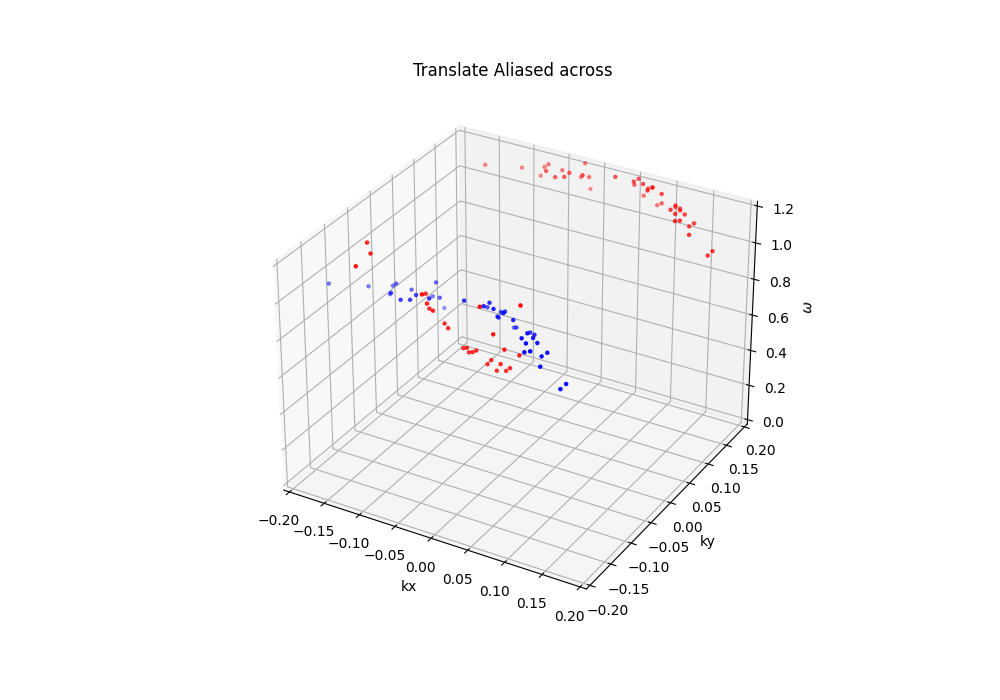

In [115]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D( translated_alias_trip[0],  translated_alias_trip[1],  translated_alias_trip[2], color = "blue", s = 5)

ax.scatter3D(all_triplets[0], all_triplets[1], all_triplets[2], color = "red", s = 5)
plt.title("Translate Aliased across")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.7) Reflection through y direction

In [116]:
# Reflection through y = -0.17
reflection_plane = -np.max(np.abs(all_triplets[1][cond_nonalias]))
reflected_point_y = (translated_alias_trip[0], 2 * reflection_plane - translated_alias_trip[1], translated_alias_trip[2])

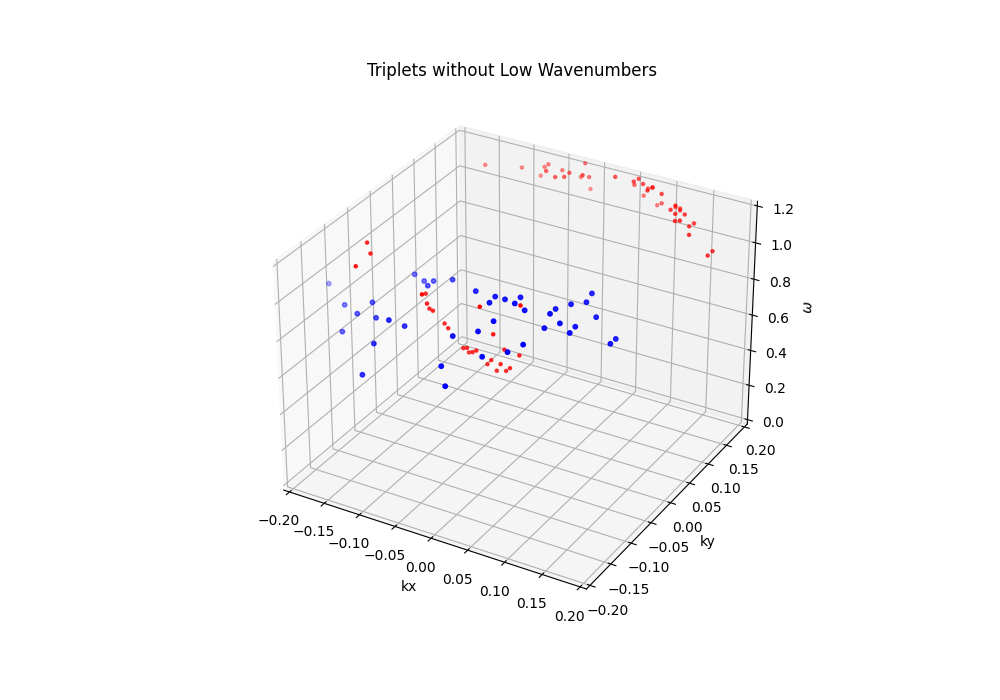

In [117]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_triplets[0], all_triplets[1], all_triplets[2], color = "red", s = 5)

ax.scatter3D(reflected_point_y[0], reflected_point_y[1], reflected_point_y[2], color = "blue", s = 10)

plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

## 2.8) Reflection through z direction

In [118]:
# Reflection through z = 1.2
reflection_plane_z = np.max(np.abs(all_triplets[2][cond_nonalias]))
reflected_point_z = (reflected_point_y[0], reflected_point_y[1], 2 * reflection_plane_z - reflected_point_y[2])

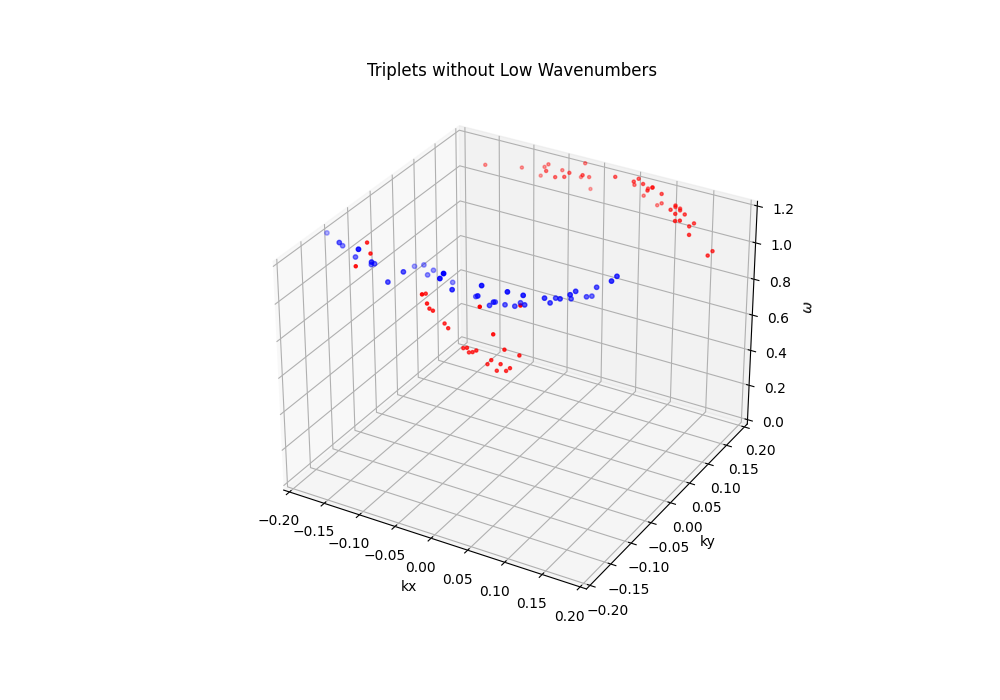

In [119]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_triplets[0], all_triplets[1], all_triplets[2], color = "red", s = 5)

ax.scatter3D(reflected_point_z[0], reflected_point_z[1], reflected_point_z[2], color = "blue", s = 10)

plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

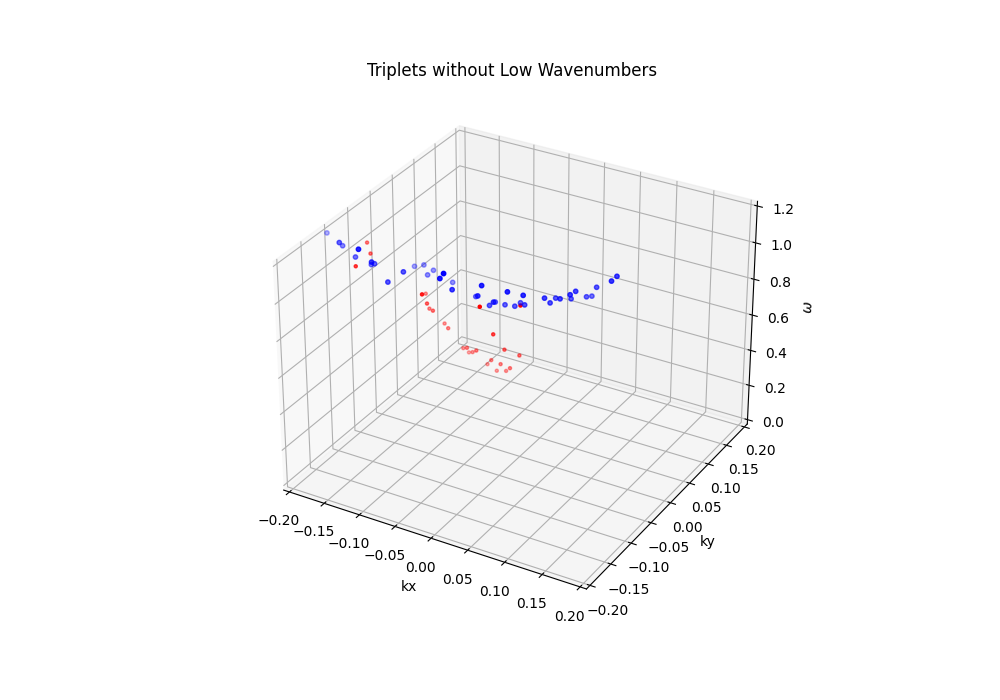

In [120]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(all_triplets[0][cond_nonalias], all_triplets[1][cond_nonalias], all_triplets[2][cond_nonalias], color = "red", s = 5)

ax.scatter3D(reflected_point_z[0], reflected_point_z[1], reflected_point_z[2], color = "blue", s = 10)

plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

In [121]:
kx_trip = np.concatenate(all_triplets[0][cond_nonalias], reflected_point_z[0])
ky_trip = np.concatenate(all_triplets[1][cond_nonalias], reflected_point_z[1])
w_trip = np.concatenate(all_triplets[2][cond_nonalias], reflected_point_z[2])

TypeError: only integer scalar arrays can be converted to a scalar index

In [127]:
reflected_point_z[0]

array([ 0.19039955,  0.19039955,  0.16501295,  0.15231964,  0.15231964,
        0.15231964,  0.15231964,  0.13962634,  0.13962634,  0.12693304,
        0.12693304,  0.12693304,  0.11423973,  0.10154643,  0.10154643,
        0.08885313,  0.08885313,  0.07615982,  0.07615982,  0.07615982,
        0.06346652,  0.06346652,  0.06346652,  0.05077321,  0.03807991,
        0.03807991,  0.03807991, -0.        , -0.02538661, -0.02538661,
       -0.02538661, -0.03807991, -0.03807991, -0.05077321, -0.05077321,
       -0.05077321, -0.06346652, -0.07615982, -0.08885313, -0.10154643,
       -0.11423973, -0.15231964])

In [126]:
all_triplets[0][cond_nonalias]

array([ 0.08885313,  0.05077321,  0.05077321,  0.03807991,  0.03807991,
        0.03807991,  0.02538661,  0.02538661,  0.0126933 ,  0.0126933 ,
       -0.        , -0.        , -0.0126933 , -0.0126933 , -0.02538661,
       -0.02538661, -0.02538661, -0.03807991, -0.05077321, -0.05077321,
       -0.05077321, -0.06346652, -0.07615982, -0.11423973, -0.12693304,
       -0.13962634])

In [103]:
np.argmax(-ky_trip[cond_high_k])

51

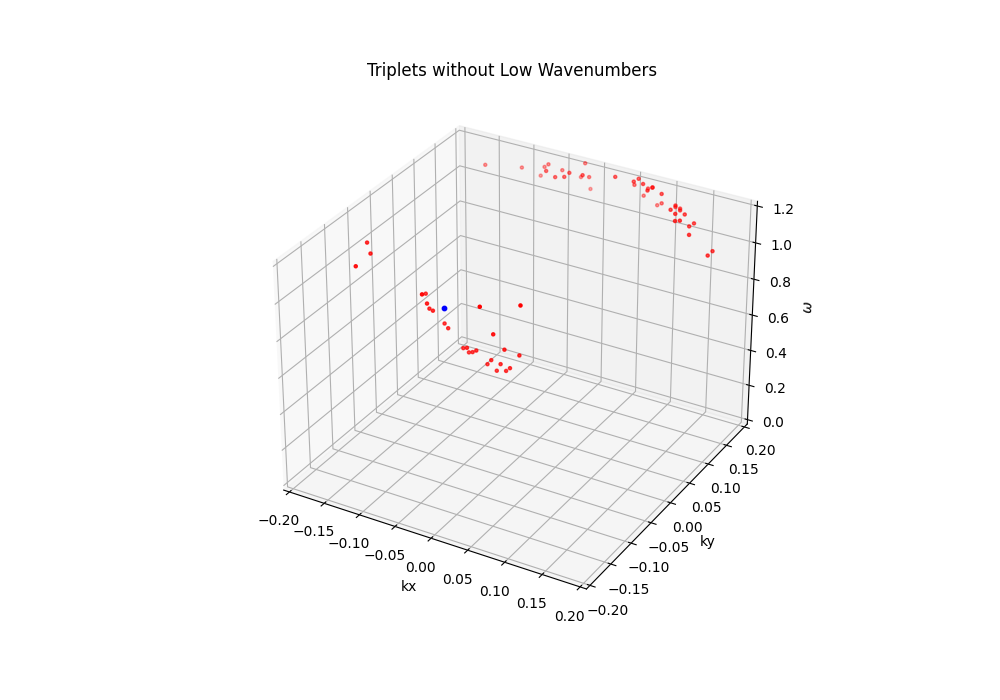

In [104]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k], color = "red", s = 5)

ax.scatter3D(-kx_trip[cond_high_k][51], -ky_trip[cond_high_k][51] + 2*np.min(-ky_trip[cond_high_k]), w0[cond_high_k][51], color = "blue", s = 10)

plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

In [105]:
# Your point in 3D space
point = (-kx_trip[cond_high_k][51], -ky_trip[cond_high_k][51] + 2*np.min(-ky_trip[cond_high_k]), w0[cond_high_k][51])

# Reflection through y = -0.17
reflection_plane = np.min(-ky_trip[cond_high_k])
reflected_point = (point[0], 2 * reflection_plane - point[1], point[2])

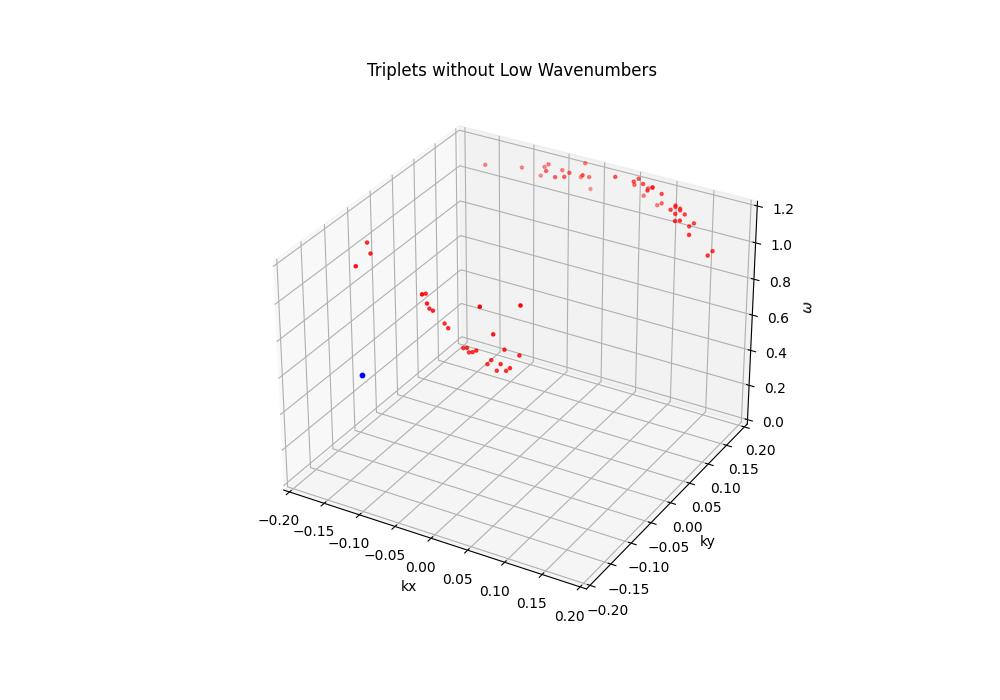

In [106]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k], color = "red", s = 5)

ax.scatter3D(reflected_point[0], reflected_point[1], reflected_point[2], color = "blue", s = 10)

plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.2, 0.2])
ax.set_zlim([0,1.2])
 
# show plot
plt.show()

In [107]:
# Assuming reflected_point is the point after the first reflection
reflected_point = (reflected_point[0], reflected_point[1], reflected_point[2])

# Reflection through z = 1.2
reflection_plane_z = 1.2
reflected_point_z = (reflected_point[0], reflected_point[1], 2 * reflection_plane_z - reflected_point[2])

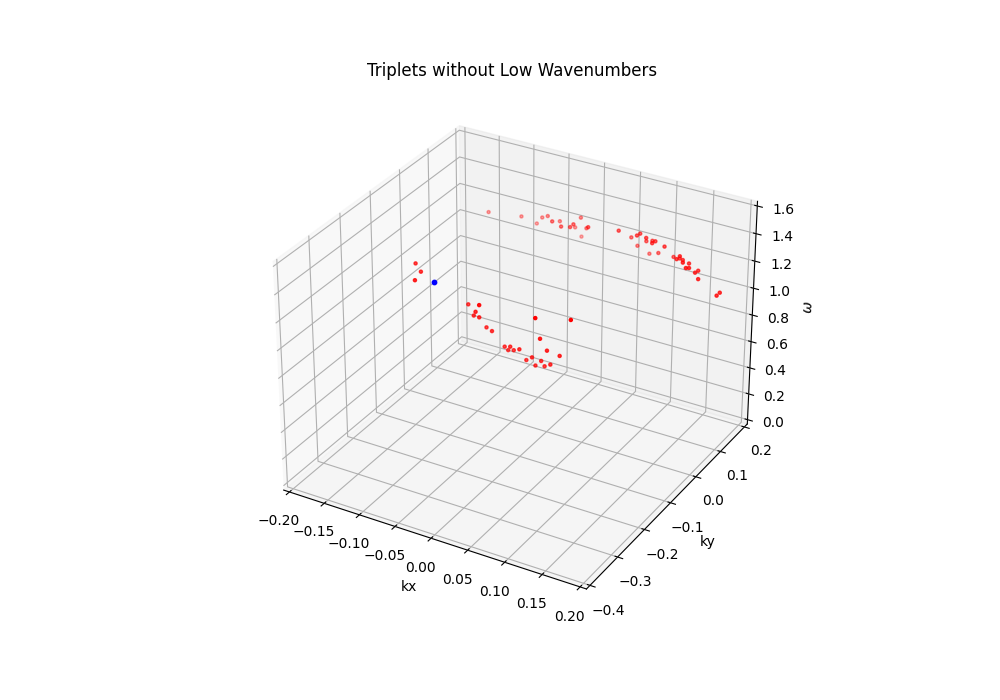

In [108]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(-kx_trip[cond_high_k], -ky_trip[cond_high_k], w0[cond_high_k], color = "red", s = 5)

ax.scatter3D(reflected_point_z[0], reflected_point_z[1], reflected_point_z[2], color = "blue", s = 10)

plt.title("Triplets without Low Wavenumbers")

ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('$\omega$')

ax.set_xlim([-0.2, 0.2])  # Adjust the limits as needed for your data
ax.set_ylim([-0.4, 0.2])
ax.set_zlim([0,1.6])
 
# show plot
plt.show()

In [28]:
np.min(-ky_trip[cond_high_k])

-0.1777062511121499